# Tutorial for `hmat.jl`

This tutorial will show the basic usage of the $\mathcal{H}$-matrix software, which implements construction, LU and backslash operator. 

Basically, we focus on solving the linear system 
$$Ax=b$$
where $A$ can be a dense matrix. 

The basic idea is to construction a **fine** $\mathcal{H}$-matrix approximation $H_1$, and a **coarse** $\mathcal{H}$-matrix $H_2$. Since the structure of the latter is coarse, we are then able to carry out LU decomposition of $H_2$ in an inexpensive way. The LU factorized $H_2$ can then serve as a preconditioner. Mathematically we will be solving
$$H_2^{-1}H_1x = H_2^{-1}b$$
and use the solution $\hat x$ to approximate the solution $x^*$ to $Ax=b$.

Throught the notebook, we will only tune two parameters for the $\mathcal{H}$-matrix construction: 
* Compression tolerance $\varepsilon_1$, which controls the tradeoff between accuracy and cost for constructing  $\mathcal{H}$-matrix.

* Low rank matrix addition tolerance $\varepsilon_2$. For the $\mathcal{H}$-LU algorithm we use, the accuracy for low rank matrix addition has substantial impact on the cost and accuracy of $\mathcal{H}$-LU algorithm. The tolerance parameter will lend us a control over the tradeoff.

### Installation Guide

An easy way to install and configure is to run `install.jl` through julia REPL

```
julia> include("install.jl")
```
It will also try to compile some C/C++ scripts. If it fails, the users are required to modify CMakeLists.txt and rerun the script.

In [13]:
include("hmat.jl")

rel_error (generic function with 1 method)

## Example 1: $\mathcal{H}$-matrix Construction 

One way to construct $\mathcal{H}$-matrix is through the black-box routine 
```
function construct_hmat(A::Array{Float64}, c::Cluster, Nleaf::Int64, Rrank::Int64,
                eps::Float64, MaxBlock::Int64)
```
which requires the user to input

* `A`: a dense matrix $A$

* `c`: a cluster structure 

* `Nleaf`: Maximum block size of the leaf blocks. Usually `Nleaf=64` is a good choice (which can better leverage the dense linear algebra engine such as BLAS without sacrificing too much low rank approximation)

* `Rrank`: Maximum rank for each low-rank block

* `eps` : $\varepsilon_1$ as mentioned

* `MaxBlock` : The largest possible block size for the low rank blocks. Usually we can choose `MaxBLock`$\approx N/4$, where $N$ is the matrix size 

If no information is available, we can use `uniform_cluster` and `cluster_from_list` to construct a linear cluster structure. For example, if the matrix size is 2000, we want each leaf block have size approximately equal to $64$, we have

In [23]:
cs = uniform_cluster(2000,64)
c = cluster_from_list(cs)
print(c)

2000
1024 976
512 512 512 464
256 256 256 256 256 256 256 208
128 128 128 128 128 128 128 128 128 128 128 128 128 128 128 80
64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 64 16


This indicates the cluster has 6 levels. The second level splits the rows/columns of the matrix into two, each of them has sizes 1024 or 976.

Now we construction a manufactured matrix

In [24]:
A = zeros(2000,2000)
for i = 1:2000
    for j = 1:2000
        if i==j
            A[i,j] = 100
        else
            A[i,j] = -1/(i-j)^2
        end
    end
end

We construct a $\mathcal{H}$-matrix out of $A$

In [25]:
Nleaf = 64
Rrank = 5
e = 1e-2
MaxBlock = div(2000,4)
H, _ = construct_hmat(A, c, Nleaf, Rrank, e, MaxBlock)

(Hmat
  A: Array{Float64}((0, 0)) Array{Float64}(0,0)
  B: Array{Float64}((0, 0)) Array{Float64}(0,0)
  C: Array{Float64}((0, 0)) Array{Float64}(0,0)
  P: Array{Int64}((0,)) Int64[]
  is_rkmatrix: Bool false
  is_fullmatrix: Bool false
  is_hmat: Bool true
  m: Int64 2000
  n: Int64 2000
  children: Array{Hmat}((2, 2))
  s: Cluster
  t: Cluster
, [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000])

The $\mathcal{H}$-matrix can be visualized using `matshow`. The yellow part corresponds to a dense matrix, while the green part corresponds to a low rank matrix.

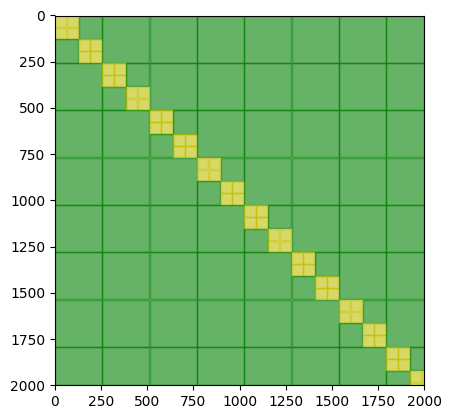

In [26]:
matshow(H)

## Example 2: Matrix Vector Multiplication

After constructing the H matrix, we get the fast matrix vector multiplication for free thanks to the library. The operator `*` is overloaded and therefore we can directly write `H*x`

In [36]:
x = rand(2000)
@time y1 = A*x
@time y2 = H*x
@show norm(y2-y1)/norm(y1)

  0.001847 seconds (5 allocations: 15.906 KiB)
  0.001493 seconds (441 allocations: 45.813 KiB)
norm(y2 - y1) / norm(y1) = 7.06422406459368e-5


7.06422406459368e-5

At this stage, the matrix vector multiplication does not have advantage over the dense matrix vector multiplication. This is because the matrix size is still too small. We will later see that H matrix vector multiplication will have linear complexity while dense ones have quadratic cost. 

## Example 3. LU decomposition

Now we consider the LU decomposition of the $\mathcal{H}$-matrix. `lu!` is implemented and accepts two arguments
* `H`: $\mathcal{H}$-matrix

* `eps`: $\varepsilon_2$ as mentioned

In [46]:
HH = copy(H)
@time lu!(HH, 1e-2);

y = A*x
@time lu!(A)
@time A\y
@time xhat = HH\y
@show norm(x-xhat)/norm(x)

  0.038238 seconds (23.82 k allocations: 13.982 MiB)
  0.071469 seconds (6 allocations: 8.125 KiB)
  0.067516 seconds (9 allocations: 30.541 MiB, 7.05% gc time)
  0.000966 seconds (440 allocations: 56.172 KiB)
norm(x - xhat) / norm(x) = 0.01539032691121676


0.01539032691121676

In [48]:
include("tools.jl")

hprecond (generic function with 1 method)

## Example 4: Iterative Solvers

Consider the matrix $A$ where $A_{ij} = -\frac{1}{h^2|i-j|^2}$ and $A_{ii} = -\sum_{j\neq i} A_{ij} + 1.0$. 

In [22]:
function computeA(N)
    A = zeros(N, N)
    h = 1/(N-1)
    for i = 1:N
        for j = 1:N
            if i==j
                A[i,j] = 0.0
            else
                A[i,j] = -1/(i-j)^2
            end
        end
    end
    for i = 1:N
        A[i,i] = 10.0*h^2 - sum(A[i,:])
    end
    return A
end

computeA (generic function with 1 method)

The condition number will rise dramatically like $\mathcal{O}(N^2)$, which will lead to the failure of iterative method. In these cases, using $\mathcal{H}$-LU as preconditioners will be very inviting. 

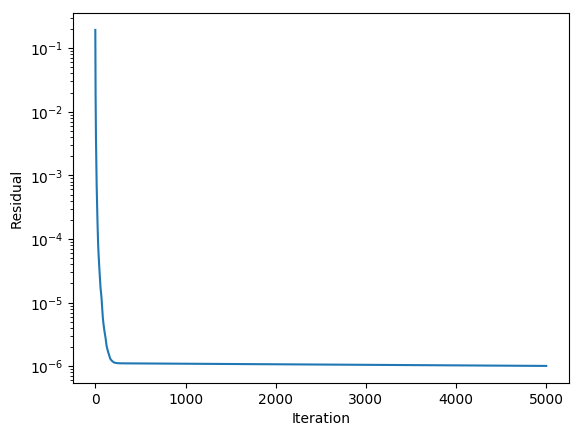

PyObject Text(24.000000000000007, 0.5, 'Residual')

In [61]:
include("tools.jl")
A = computeA(2^11)
x = rand(2^11)
y = A*x
y1, err1 = pygmres_with_call_back(A, y, nothing, false)
semilogy(err1)
xlabel("Iteration")
ylabel("Residual")

We see that without a preconditioner, the iterative method does not work well. 

Now let us construct a $\mathcal{H}$-matrix preconditioner.

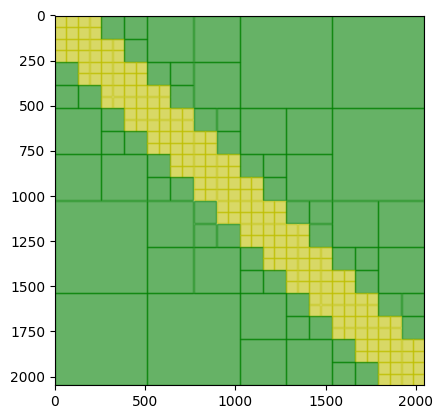

Matrix Error = 1.7451594086937555e-10
Matvec Error = 1.1275567384865632e-10


In [35]:
n = 11
A = computeA(2^n)
cs = uniform_cluster(2^n,64)
c = cluster_from_list(cs)

Nleaf = 64
Rrank = 5
e = 1e-5
MaxBlock = div(2^n,4)
H1, _ = construct_hmat(A, c, Nleaf, Rrank, e, MaxBlock)
verify_matrix_error(H1, A)
verify_matvec_error(H1, A)
matshow(H1)

The matrix error and matvec error is very small and therefore $H_1$ is a good approximation to the original matrix. Plus, the figure shows that the $\mathcal{H}$-matrix is not populated with dense blocks and therefore we expect efficient matrix vector multiplication and LU. 

We now do the LU decomposition directly on H1 instead of on a newly construction "coarse" $\mathcal{H}$-matrix.

In [58]:
HH = copy(H1)
lu!(HH, 1e-3)
verify_lu_error(H1, HH, A)

[Operator] LU Error = 0.00036862045248688136
[Matrix  ] LU Error = 0.00036862045248688136
[Operator] Solve Error = 0.8816351531270361
[Matrix  ] Solve Error = 0.8475001344392191


Now we consider using `HH` as a preconditioner. The function we will use is `function pygmres_with_call_back(A, b, op=nothing, verbose=true)` where
* `A`: Matrix or $\mathcal{H}$-matrix or linear operator 
* `b`: Right hand size
* `op`: Matrix or $\mathcal{H}$-matrix or linear operator. It is used as preconditioner
* `verbose`: whether to print iteration error or not

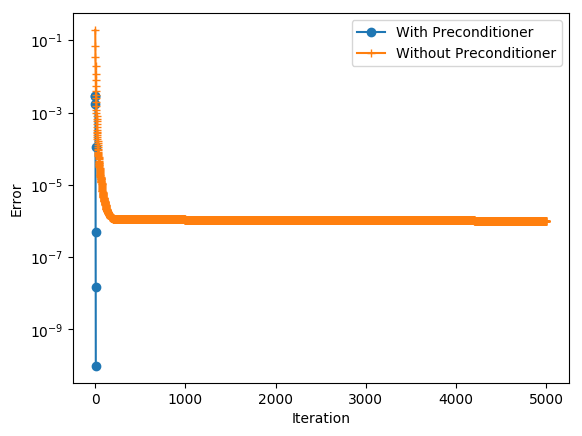

Error1 (Without Preconditioner) = 0.7780634086720646
Error2 (With Preconditioner)= 1.2684387709956866e-8


PyObject Text(24.000000000000007, 0.5, 'Error')

In [63]:
y2, err2 = pygmres_with_call_back(H1, y, HH, false);
println("Error1 (Without Preconditioner) = ", rel_error(y1, x))
println("Error2 (With Preconditioner)= ", rel_error(y2, x))
semilogy(err2,"o-",label="With Preconditioner")
semilogy(err1, "+-", label="Without Preconditioner")
legend()
xlabel("Iteration")
ylabel("Error")


**Note**: note that the solve error is not so satisfactory even though the LU error is small. It is not contradiction: since the original system is quite ill-conditioned, and $\mathcal{H}$-LU essentially does no pivoting except within the leaf nodes, the solve process may be erroneous.

## Other Notes

`hmat.jl` -- basic data structure for $\mathcal{H}$-matrix, LU algorithm

`harithm.jl` -- matrix add, multiplication, etc.

`cluster.jl` -- algorithms related to cluster.

`tools.jl` -- iterative methods

`test_Merton_kernel.jl` -- test scripts